## Import libraries

In [1]:
import sys, os

basepath = os.path.abspath("../..")
sys.path.append(basepath)
sys.path.append(basepath + "/Operators")
sys.path.append(basepath + "/Utilities")

import numpy as np
import scipy as sp
import time
import matplotlib.pyplot as plt
%matplotlib inline

import DevitoOperators
from DevitoUtils import create_model, plot_image, plot_image_xy, plot_images_grid_xy, plot_shotrecord
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_velocity, plot_perturbation, demo_model, AcquisitionGeometry

from devito import configuration
configuration['log-level'] = 'WARNING'

from devito import configuration
configuration['log-level'] = 'WARNING'

## Code to run

Source coords:  [[1495.   20.]]
Nt =  655


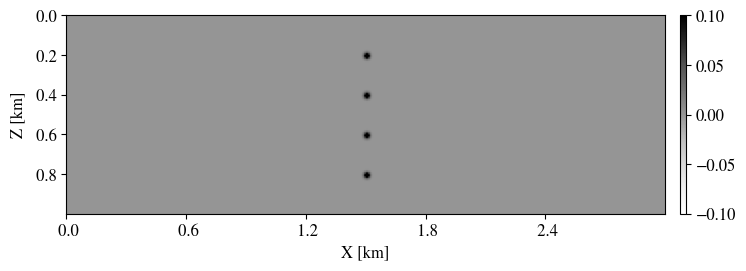

In [18]:
filestr = "point_scatterers_image_cig"

# Create params dicts
params = {
    "Nx": 300,
    "Nz": 100,
    "Nt": 100,   # this has to be updated later
    "nbl": 75,
    "Ns": 1,
    "Nr": 300,
    "so": 4,
    "to": 2
}

# Create velocity
vel = create_model(shape=(params["Nx"], params["Nz"]))
vel.vp.data[:, :] = 2.0

# Simulation time, wavelet
t0 = 0.
tn = 2000.  # Simulation last 2 second (2000 ms)
f0 = 0.015  # Source peak frequency is 10Hz (0.010 kHz)

# Reflection acquisition geometry (sources and receivers are equally spaced in X direction)
src_depth = 20.0  # Depth is 20m
rec_depth = 20.0  # Depth is 20m

src_coord = np.empty((params["Ns"], 2))
# src_coord[:, 0] = np.linspace(0, vel.domain_size[0], num=params["Ns"])
src_coord[:, 0] = vel.domain_size[0] / 2.0
src_coord[:, 1] = src_depth

print("Source coords: ", src_coord)

rec_coord = np.empty((params["Nr"], 2))
rec_coord[:, 0] = np.linspace(0, vel.domain_size[0], num=params["Nr"])
rec_coord[:, 1] = rec_depth

# Create the geometry objects for background velocity models
src_dummy = np.empty((1, 2))

src_dummy[0, :] = src_coord[int(src_coord.shape[0] / 2), :]
geometry = AcquisitionGeometry(vel, rec_coord, src_dummy, t0, tn, f0=f0, src_type='Ricker')
params["Nt"] = geometry.nt
print("Nt = ", params["Nt"])
del src_dummy

# Define a solver object
solver = AcousticWaveSolver(vel, geometry, space_order=params["so"])

# Create point scatterers
dm = np.zeros((params["Nt"], params["Nx"], params["Nz"]), dtype=np.float32)
temp = np.zeros((params["Nx"], params["Nz"]), dtype=np.float32)
temp[int(params["Nx"] / 2), int(params["Nz"] * 0.2)] = 1.0
temp[int(params["Nx"] / 2), int(params["Nz"] * 0.4)] = 1.0
temp[int(params["Nx"] / 2), int(params["Nz"] * 0.6)] = 1.0
temp[int(params["Nx"] / 2), int(params["Nz"] * 0.8)] = 1.0
temp = sp.ndimage.gaussian_filter(input=temp, sigma=1, mode="nearest")
for i in range(params["Nt"]):
    dm[i, :, :] = temp


plot_image_xy(
    dm[100, :, :].T, 
    x0=vel.origin[0], xn=vel.origin[0]+vel.domain_size[0], 
    y0=vel.origin[1], yn=vel.origin[1]+vel.domain_size[1], 
    scale=0.1, clip=1.0, colorbar=True,
    ylabel="Z [km]", xlabel="X [km]", 
    grid="off", aspect="equal", 
    fontname="STIXGeneral", fontsize=12,
    savefig_fname=basepath + "/Fig/p01_point_scatterers_image.pdf"
)

In [19]:
# Perform Born modeling and generate data
td_born_data_true = np.zeros((params["Ns"], params["Nt"], params["Nr"]), dtype=np.float32)
DevitoOperators.td_born_forward(
    model_pert=dm,
    born_data=td_born_data_true,
    src_coords=src_coord,
    vel=vel,
    geometry=geometry,
    solver=solver,
    params=params
)

# Image the data
dm_image = np.zeros((params["Nt"], params["Nx"], params["Nz"]), dtype=np.float32)
DevitoOperators.td_born_adjoint(
    born_data=td_born_data_true, 
    model_pert=dm_image,
    src_coords=src_coord,
    vel=vel,
    geometry=geometry,
    solver=solver,
    params=params
)

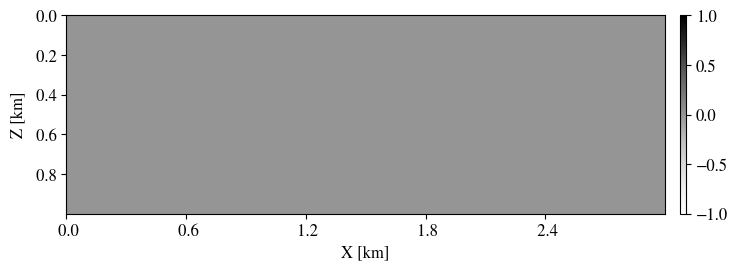

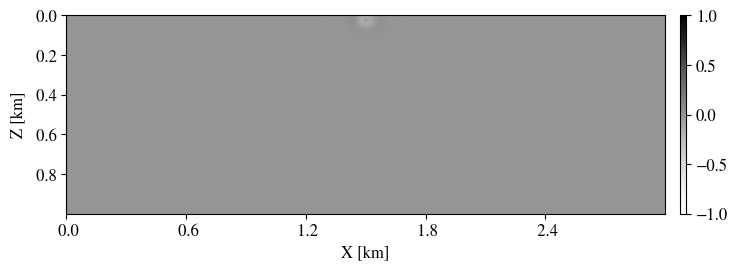

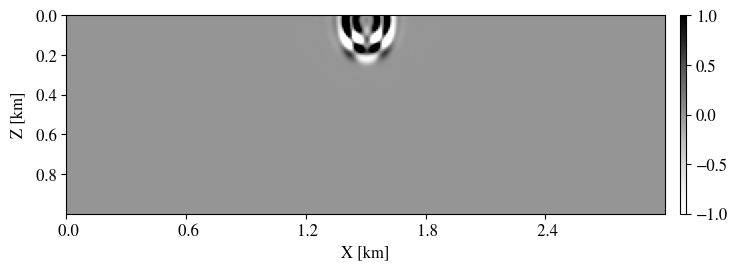

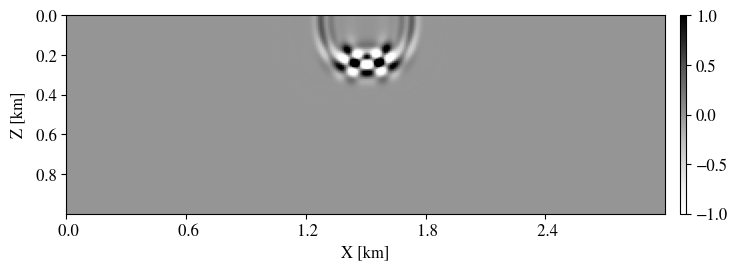

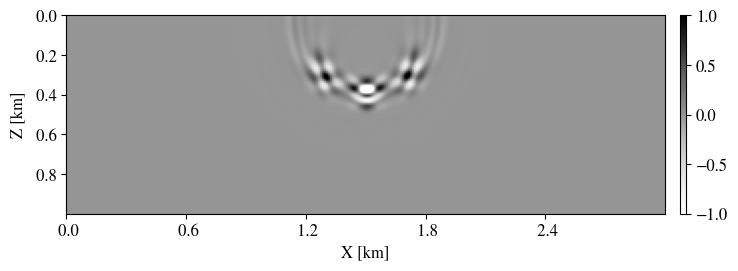

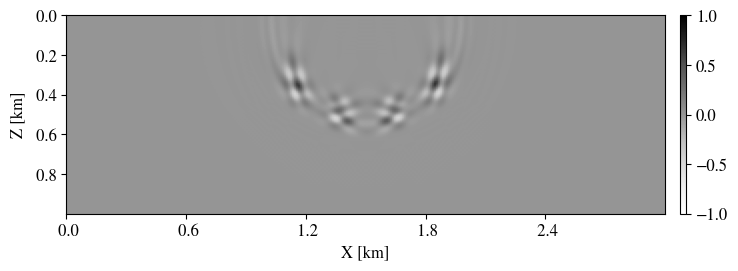

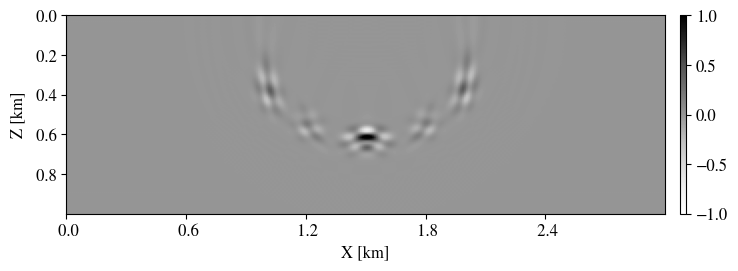

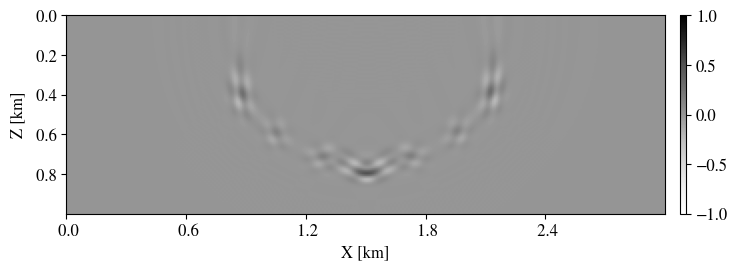

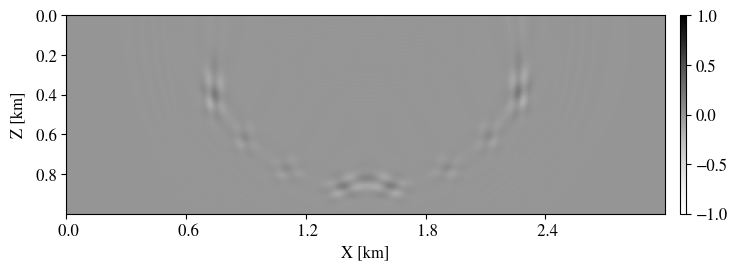

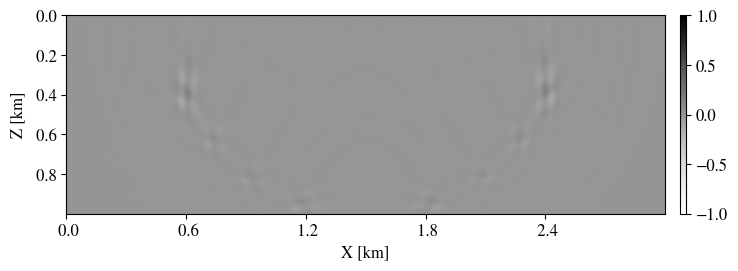

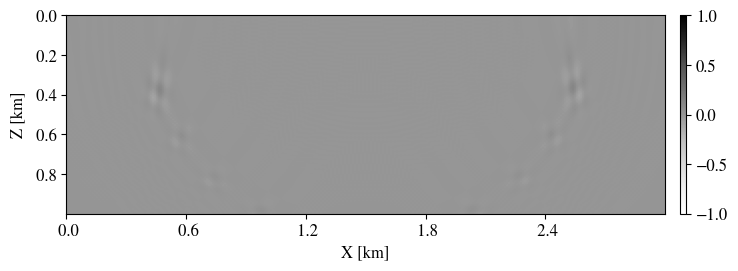

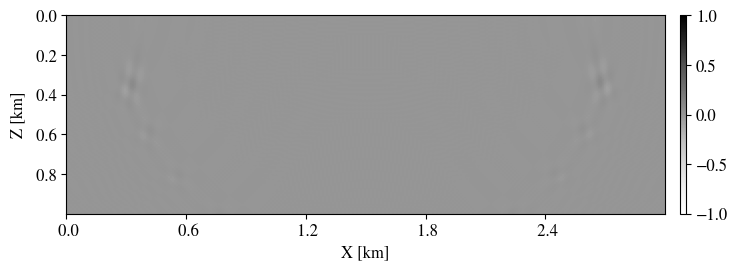

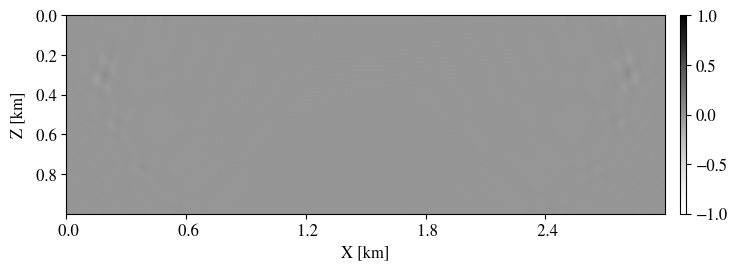

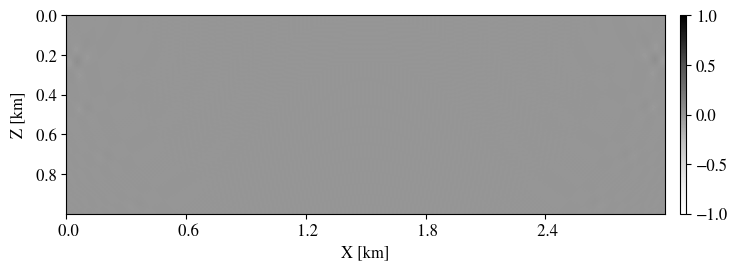

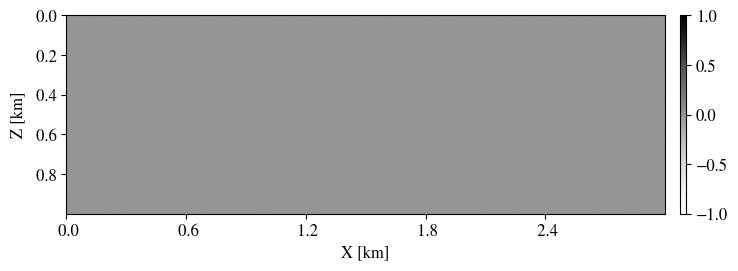

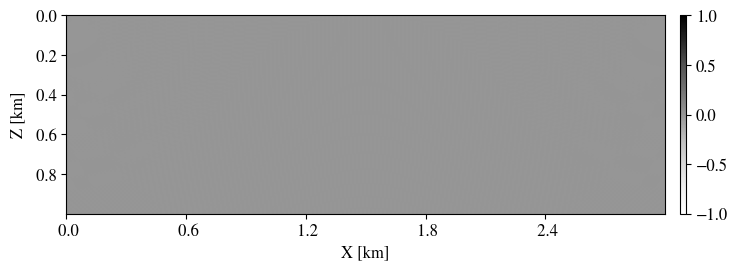

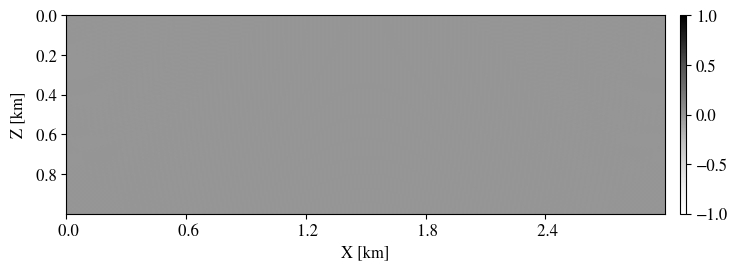

In [20]:
for i in range(0, int(params["Nt"]/2), 20):

    plot_image_xy(
        dm_image[i, :, :].T, 
        x0=vel.origin[0], xn=vel.origin[0]+vel.domain_size[0], 
        y0=vel.origin[1], yn=vel.origin[1]+vel.domain_size[1], 
        scale=1.0, clip=1.0, colorbar=True,
        ylabel="Z [km]", xlabel="X [km]", 
        grid="off", aspect="equal", 
        fontname="STIXGeneral", fontsize=12,
        savefig_fname=basepath + "/Fig/p01_point_scatterers_image.pdf"
    )

In [21]:
plot_image_xy(
        np.sum(dm_image, axis=0).T, 
        x0=vel.origin[0], xn=vel.origin[0]+vel.domain_size[0], 
        y0=vel.origin[1], yn=vel.origin[1]+vel.domain_size[1], 
        scale=20.0, clip=1.0, colorbar=True,
        ylabel="Z [km]", xlabel="X [km]", 
        grid="on", aspect="equal", 
        fontname="STIXGeneral", fontsize=12,
        savefig_dir=basepath + "/Fig/p01_point_scatterers_image.pdf"
    )

TypeError: plot_image_xy() got an unexpected keyword argument 'savefig_dir'

Depth Z value:  0.0  km


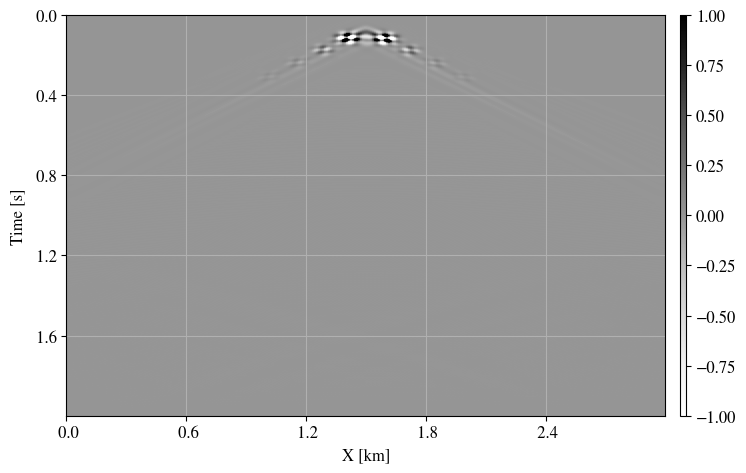

Depth Z value:  0.1  km


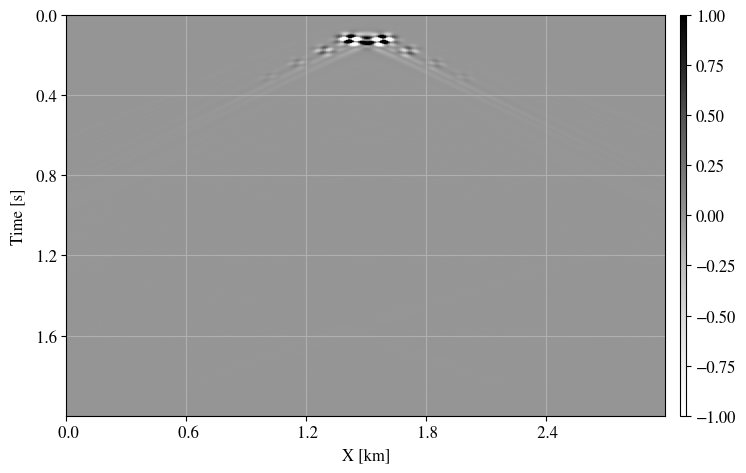

Depth Z value:  0.2  km


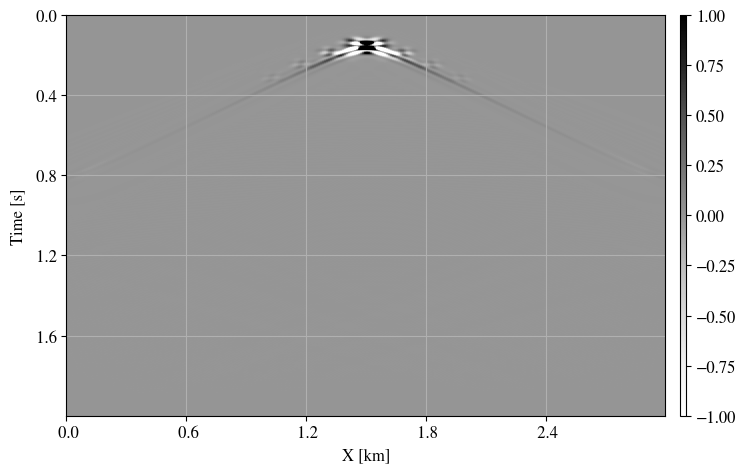

Depth Z value:  0.3  km


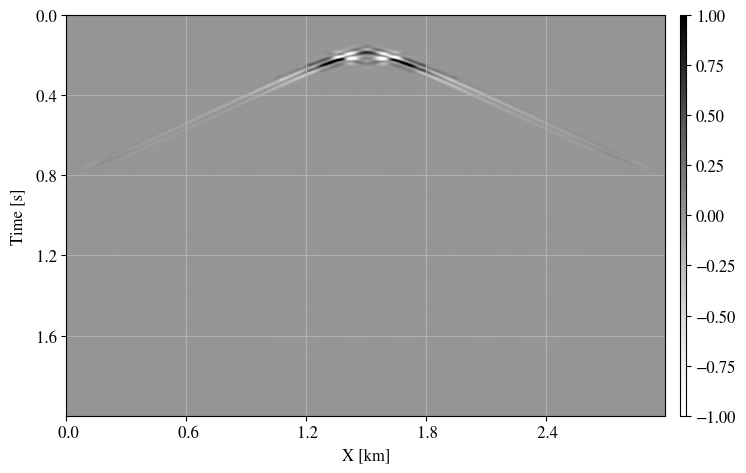

Depth Z value:  0.4  km


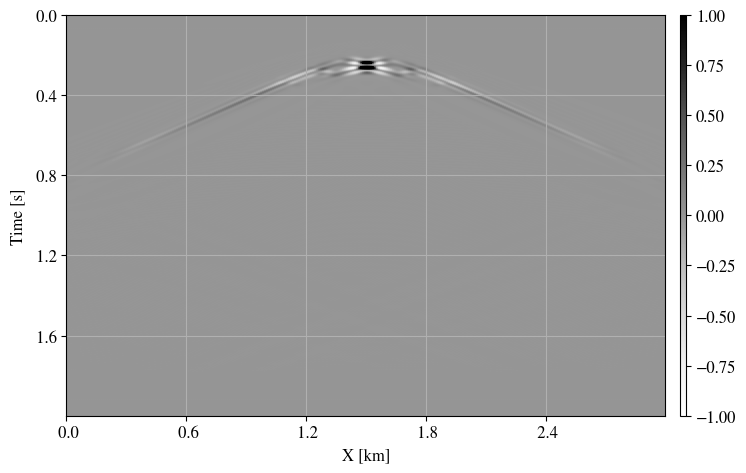

Depth Z value:  0.5  km


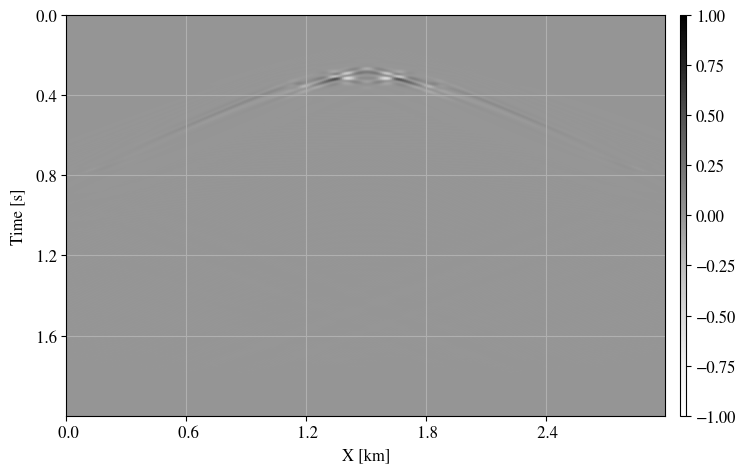

Depth Z value:  0.6  km


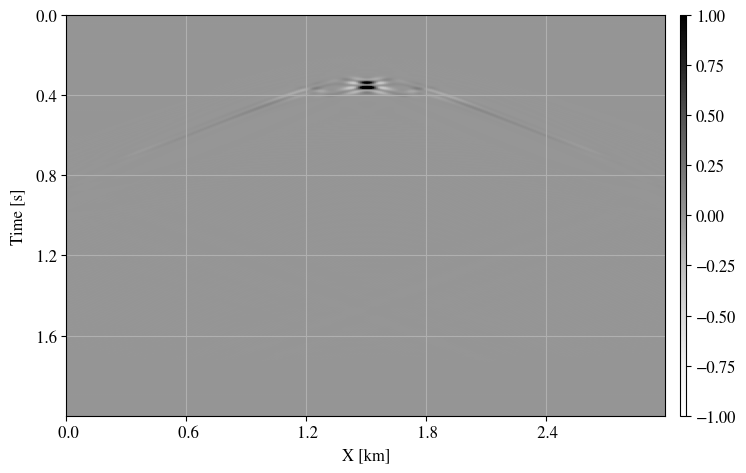

Depth Z value:  0.7  km


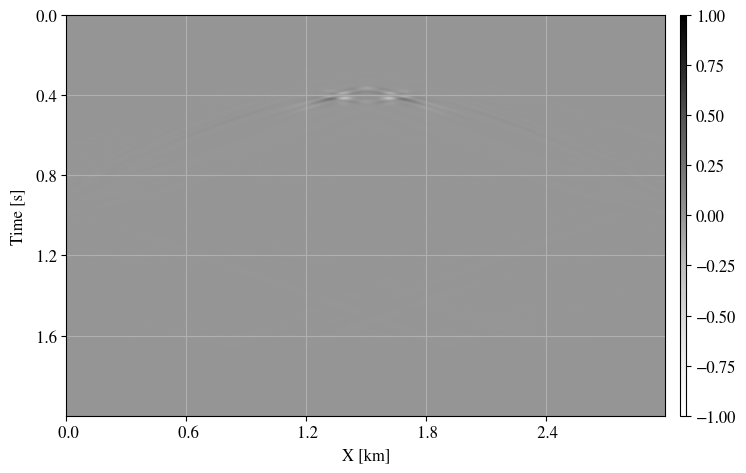

Depth Z value:  0.8  km


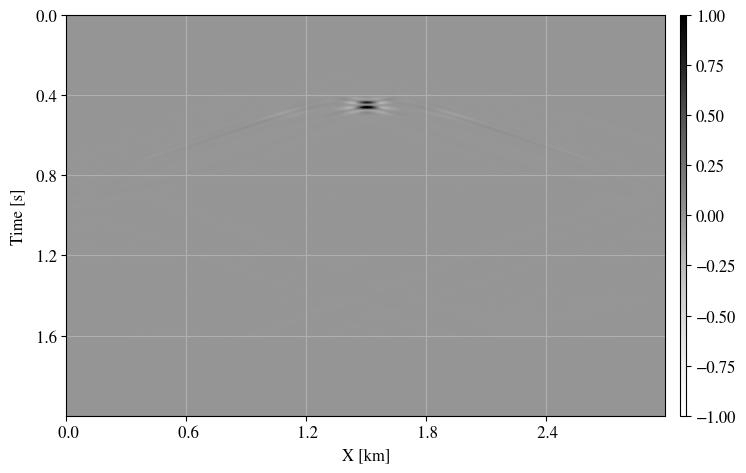

Depth Z value:  0.9  km


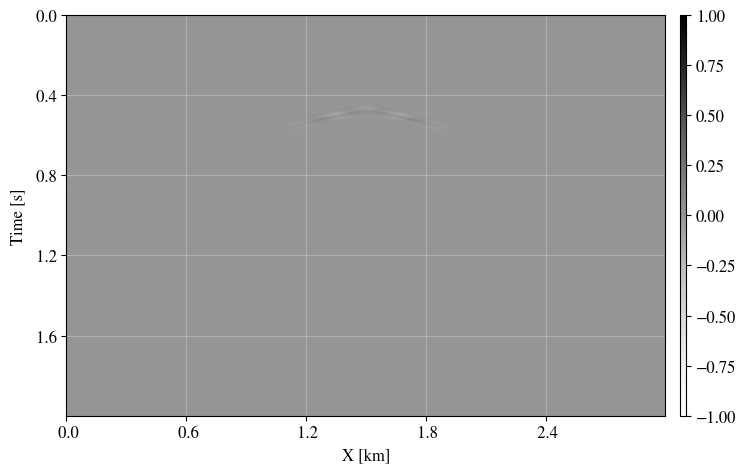

In [23]:
for i in range(0, params["Nz"], 10):
    
    print("Depth Z value: ", i * 10 / 1000, " km")
    plot_image_xy(
        dm_image[:, :, i], 
        x0=vel.origin[0], xn=vel.origin[0]+vel.domain_size[0], 
        y0=t0, yn=tn, 
        scale=1.0, clip=1.0, colorbar=True,
        ylabel="Time [s]", xlabel="X [km]", 
        grid="on", aspect="equal", 
        fontname="STIXGeneral", fontsize=12,
        savefig_fname=basepath + "/Fig/p01_point_scatterers_image.pdf"
    )

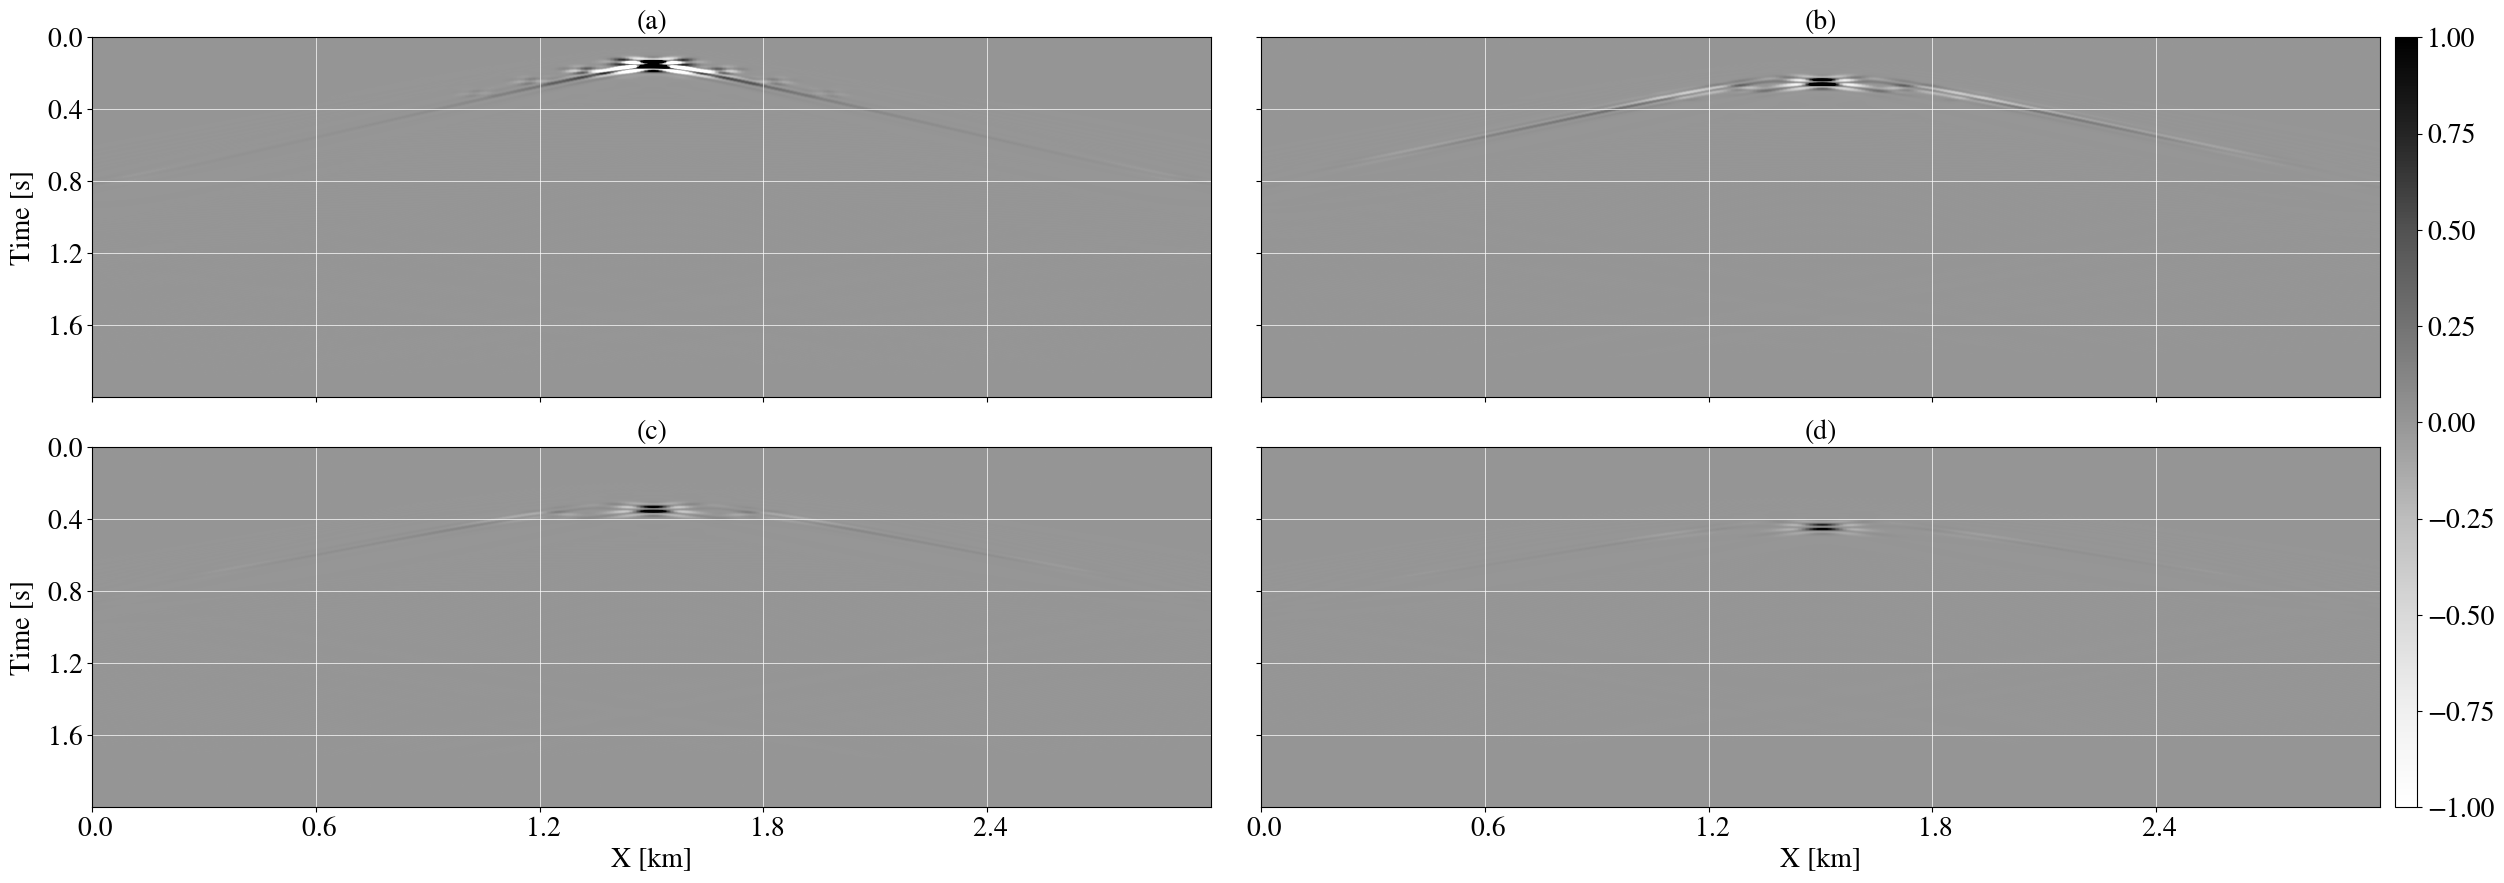

In [24]:
image_nrows = 2
image_ncols = 2
image_arr = np.zeros(shape=(image_nrows, image_ncols, params["Nt"], params["Nx"]), dtype=np.float32)
image_arr[0, 0, :, :] = dm_image[:, :, int(params["Nz"] * 0.2)]
image_arr[0, 1, :, :] = dm_image[:, :, int(params["Nz"] * 0.4)]
image_arr[1, 0, :, :] = dm_image[:, :, int(params["Nz"] * 0.6)]
image_arr[1, 1, :, :] = dm_image[:, :, int(params["Nz"] * 0.8)]

image_titles = [["(a)", "(b)"], ["(c)", "(d)"]]

plot_images_grid_xy(
    image_grid=image_arr, image_titles=image_titles,
    x0=vel.origin[0], xn=vel.origin[0] + vel.domain_size[0], y0=t0, yn=tn, scale=1.0, vmin=None, vmax=None,
    grid="on", aspect="auto", cmap="Greys", axes_pad=0.5, colorbar=True, clip=1.0,
    xlabel="X [km]", ylabel="Time [s]",
    fontname="STIXGeneral", fontsize=20,
    nxticks=5, nyticks=5,
    savefig_fname=basepath + "/Fig/p01_point_scatterers_images_adjoint.pdf"
)

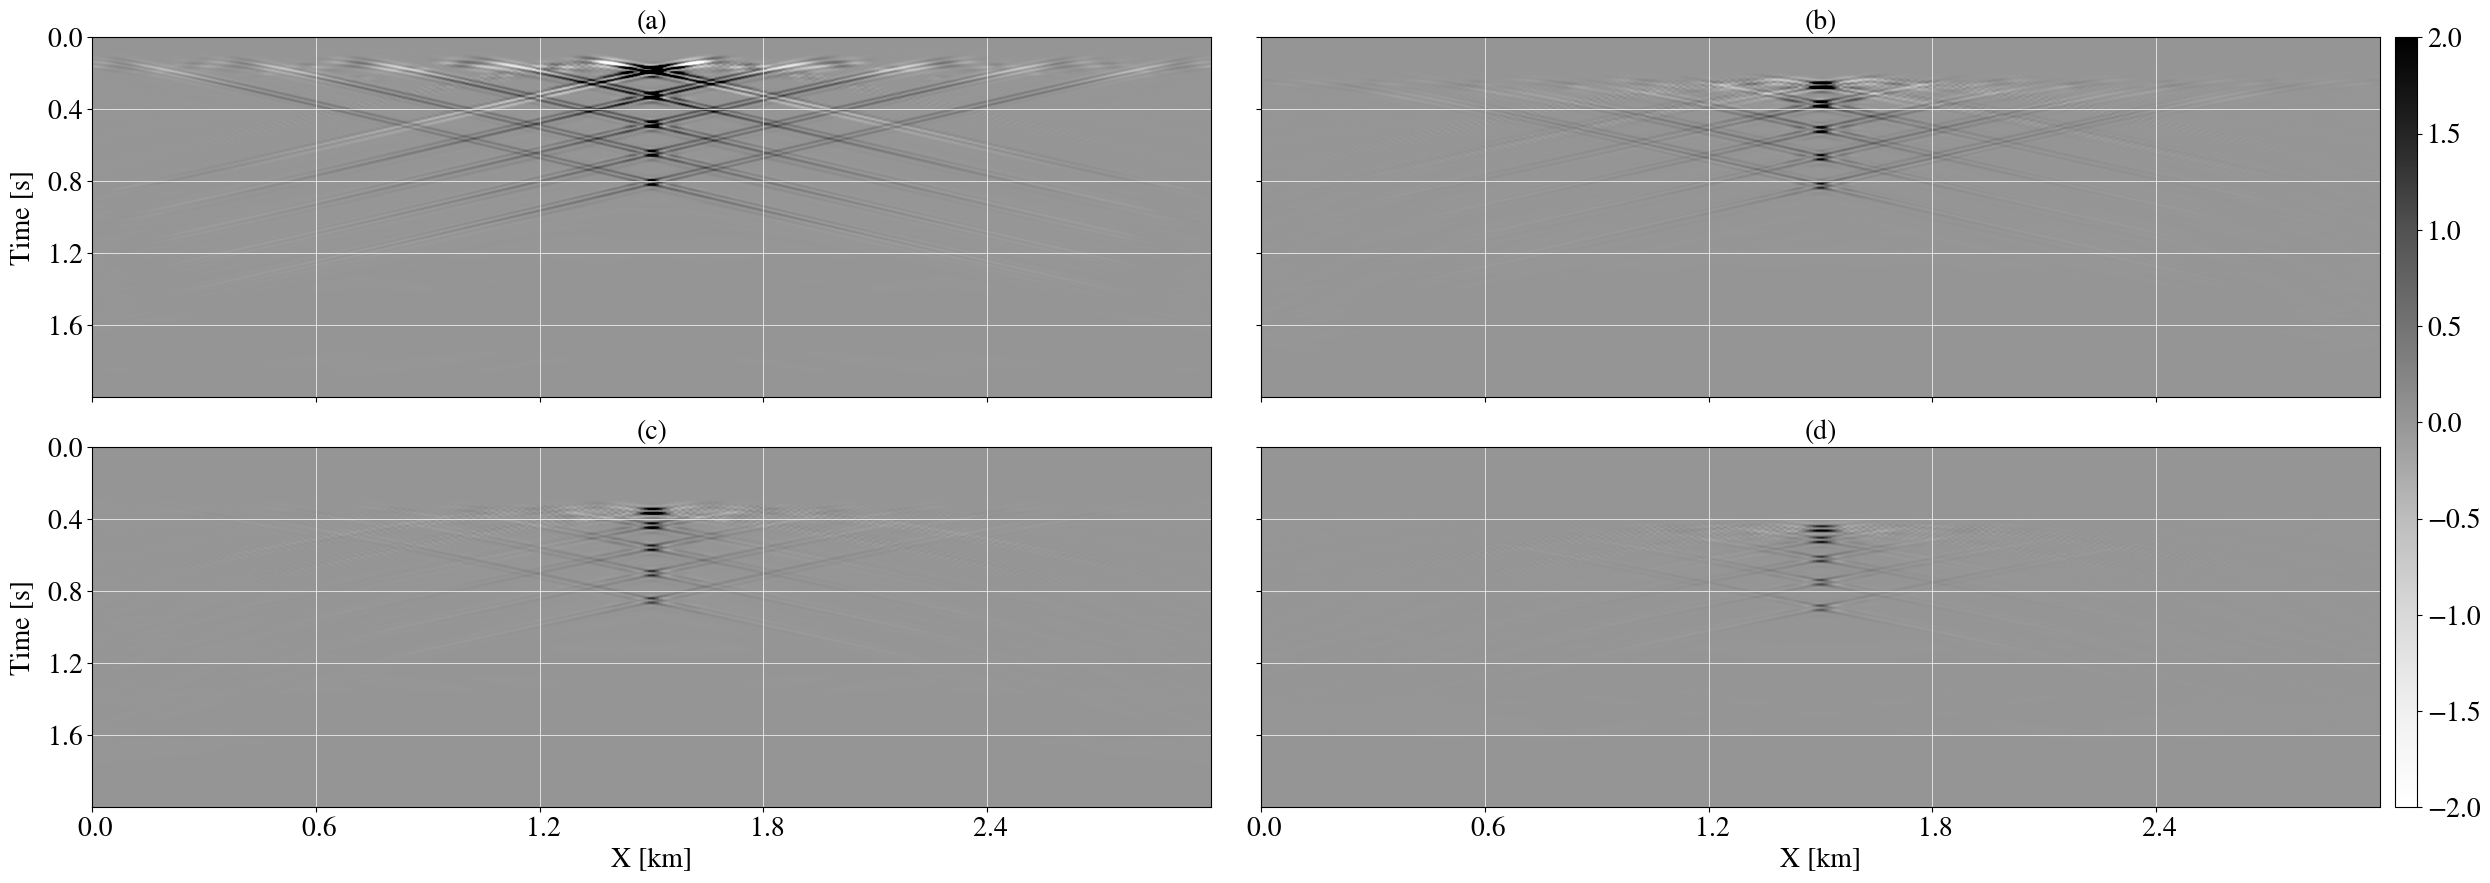

In [25]:
def multi_source_10():

    filestr = "p01_point_scatterers_multi_source_10"

    # Create params dicts
    params = {
        "Nx": 300,
        "Nz": 100,
        "Nt": 100,  # this has to be updated later
        "nbl": 75,
        "Ns": 10,
        "Nr": 300,
        "so": 4,
        "to": 2
    }

    # Create velocity
    vel = create_model(shape=(params["Nx"], params["Nz"]))
    vel.vp.data[:, :] = 2.0

    # Simulation time, wavelet
    t0 = 0.
    tn = 2000.  # Simulation last 2 second (2000 ms)
    f0 = 0.015  # Source peak frequency is 15Hz (0.015 kHz)

    # Reflection acquisition geometry (sources and receivers are equally spaced in X direction)
    src_depth = 20.0  # Depth is 20m
    rec_depth = 20.0  # Depth is 20m

    src_coord = np.empty((params["Ns"], 2))
    src_coord[:, 0] = np.linspace(0, vel.domain_size[0], num=params["Ns"])
    src_coord[:, 1] = src_depth

    rec_coord = np.empty((params["Nr"], 2))
    rec_coord[:, 0] = np.linspace(0, vel.domain_size[0], num=params["Nr"])
    rec_coord[:, 1] = rec_depth

    # Create the geometry objects for background velocity models
    src_dummy = np.empty((1, 2))

    src_dummy[0, :] = src_coord[int(src_coord.shape[0] / 2), :]
    geometry = AcquisitionGeometry(vel, rec_coord, src_dummy, t0, tn, f0=f0, src_type='Ricker')
    params["Nt"] = geometry.nt
    del src_dummy

    # Define a solver object
    solver = AcousticWaveSolver(vel, geometry, space_order=params["so"])

    # Create point scatterers
    dm = np.zeros((params["Nt"], params["Nx"], params["Nz"]), dtype=np.float32)
    temp = np.zeros((params["Nx"], params["Nz"]), dtype=np.float32)
    temp[int(params["Nx"] / 2), int(params["Nz"] * 0.2)] = 1.0
    temp[int(params["Nx"] / 2), int(params["Nz"] * 0.4)] = 1.0
    temp[int(params["Nx"] / 2), int(params["Nz"] * 0.6)] = 1.0
    temp[int(params["Nx"] / 2), int(params["Nz"] * 0.8)] = 1.0
    temp = sp.ndimage.gaussian_filter(input=temp, sigma=1, mode="nearest")
    for i in range(params["Nt"]):
        dm[i, :, :] = temp

    del temp

    # Perform Born modeling and generate data
    td_born_data_true = np.zeros((params["Ns"], params["Nt"], params["Nr"]), dtype=np.float32)
    DevitoOperators.td_born_forward(
        model_pert=dm,
        born_data=td_born_data_true,
        src_coords=src_coord,
        vel=vel,
        geometry=geometry,
        solver=solver,
        params=params
    )

    # Image the data
    dm_image = np.zeros((params["Nt"], params["Nx"], params["Nz"]), dtype=np.float32)
    dm_scale = 2.0
    DevitoOperators.td_born_adjoint(
        born_data=td_born_data_true,
        model_pert=dm_image,
        src_coords=src_coord,
        vel=vel,
        geometry=geometry,
        solver=solver,
        params=params
    )

    # Plot imaged data (t-x sections at depth values 20%, 40%, 60%, 80%)
    image_nrows = 2
    image_ncols = 2
    image_arr = np.zeros(shape=(image_nrows, image_ncols, params["Nt"], params["Nx"]), dtype=np.float32)
    image_arr[0, 0, :, :] = dm_image[:, :, int(params["Nz"] * 0.2)]
    image_arr[0, 1, :, :] = dm_image[:, :, int(params["Nz"] * 0.4)]
    image_arr[1, 0, :, :] = dm_image[:, :, int(params["Nz"] * 0.6)]
    image_arr[1, 1, :, :] = dm_image[:, :, int(params["Nz"] * 0.8)]

    image_titles = [["(a)", "(b)"], ["(c)", "(d)"]]

    plot_images_grid_xy(
        image_grid=image_arr, image_titles=image_titles, axes_pad=0.5,
        x0=vel.origin[0], xn=vel.origin[0] + vel.domain_size[0], y0=t0, yn=tn, scale=dm_scale, vmin=None, vmax=None,
        grid="on", aspect="auto", cmap="Greys", colorbar=True, clip=1.0,
        xlabel="X [km]", ylabel="Time [s]",
        fontname="STIXGeneral", fontsize=20,
        nxticks=5, nyticks=5,
        savefig_fname=basepath + "/Fig/" + filestr + "_adjoint_images.pdf"
    )

multi_source_10()